In [119]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict
import pickle 
import pandas as pd

In [120]:
# Задание вытащить все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, подумайте как его обойти)
sber = '3529'
page = 1
num_per_page = 100
moscow = 1
vacs = []
while True:
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    page += 1
    vacancies = res.json()
    num_pages = vacancies.get('pages')
    vacs += vacancies.get('items')
     
    if page > num_pages:
        break


In [121]:
# Вытащите все описания этих вакансий
d = {'ids': [ el.get("id") for el in vacs], 
     'name': [ el.get("name") for el in vacs],
     'discriptions': [ el.get("snippet").get("responsibility") for el in vacs]}
vacancy = pd.DataFrame(data=d)
len(vacancy)

1324

In [122]:
#  Создайте аналогичный vacancy DataFrame только добавьте поле skills
vacancy2 = vacancy.copy()
vacancy2["skills"] = [ el.get("snippet").get('requirement') for el in vacs]
vacancy2

,ids,name,discriptions,skills
0,41058653,TeamLead Python-разработчик в SberDevices (нап...,"Руководство командой разработки микросервиса, ...",Опыт промышленного программирования на Python3...
1,41058979,Data Warehouse/BI Lead Developer,"Участие в проектировании, разработке аналитиче...",Рассматриваем кандидатов в том числе на junior...
2,41068416,Ведущий юрисконсульт (правовое сопровождение р...,Правовое сопровождение методологии розничного ...,Высшее юридическое образование. Глубокие знани...
3,41073390,Руководитель направления Комплаенс (Контроль к...,Инициирует и подготавливает бизнес-требования ...,Наличие высшего экономического или финансового...
4,41073921,Разработчик HP SM,Работа с крупнейшей в Европе инсталляцией HP S...,Имеете высшее\неполное высшее образование. Вла...
...,...,...,...,...
1319,43769010,Аналитик по отчетности,"Разработка, развитие и сопровождение системы о...",Высшее техническое/математическое/инженерное о...
1320,43770261,Бизнес _ Системный аналитик,"Сбор, анализ и формализация требований и задач...",Понимание способов взаимодействия (общения) си...
1321,43770317,"Associate | Sber CIB, Global Markets, Equity C...",Participation in origination and execution of ...,Genuine interest in Russian and global equity ...
1322,43772262,Рекрутер (IT подбор),Подбор персонала на IT вакансии компании. Пров...,"Высокая самостоятельность,организованность и и..."


In [123]:
# Переведите даты публикаций в datetime
vacancy2["published_at"] = [ el.get("published_at") for el in vacs]
vacancy2["published_at"] = pd.to_datetime(vacancy2["published_at"])
vacancy2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   ids           1324 non-null   object                               
 1   name          1324 non-null   object                               
 2   discriptions  1306 non-null   object                               
 3   skills        1318 non-null   object                               
 4   published_at  1324 non-null   datetime64[ns, pytz.FixedOffset(180)]
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), object(4)
memory usage: 51.8+ KB


In [64]:
# Постройте график опубликованных вакансий по датам
import matplotlib.pyplot as plt
vacancy2["pb_date"] = vacancy2["published_at"].dt.date
vacancy2. groupby("pb_date")["ids"].count()

pb_date
2021-03-10      9
2021-03-11     21
2021-03-12     27
2021-03-13      2
2021-03-14      2
2021-03-15     63
2021-03-16     57
2021-03-17     41
2021-03-18     58
2021-03-19     35
2021-03-20     12
2021-03-21      6
2021-03-22     69
2021-03-23     30
2021-03-24     45
2021-03-25     48
2021-03-26     29
2021-03-27      2
2021-03-29    101
2021-03-30     49
2021-03-31     73
2021-04-01     73
2021-04-02     93
2021-04-03      2
2021-04-04     20
2021-04-05    112
2021-04-06     89
2021-04-07     42
2021-04-08     62
2021-04-09     48
Name: ids, dtype: int64

In [65]:
# Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
# в понедельник публикуют максимальное количество
vacancy2["pb_wd"] = vacancy2["published_at"].apply(lambda x:("пн", "вт", "ср", "чт", "пт", "сб", "вс")[x.weekday()])
vacancy2.groupby("pb_wd")["ids"].count().sort_values(ascending=False)

pb_wd
пн    345
чт    262
пт    232
вт    225
ср    210
вс     28
сб     18
Name: ids, dtype: int64

In [66]:
# Найдите те вакансии с использованием python, которые вам интересны?
# Find vacancy 'name' == 'Бизнес аналитик', 'Аналитик данных', 'Data analyst' and 'skills' == 'Python'
tmp_name = 'Бизнес аналитик|Аналитик данных|Data analyst'.upper()
tmp_da = vacancy2[vacancy2.name.str.upper().str.contains(tmp_name)]
tmp_py = 'Python'.upper()
tmp_sk_py = vacancy2[vacancy2.skills.astype(str).str.upper().str.contains(tmp_py)]
vacancy_da_py = tmp_da[tmp_da.ids.isin(tmp_sk_py.ids)]
vacancy_da_py

,ids,name,discriptions,skills,published_at,pb_date,pb_wd
97,42171232,Data Analyst,Обеспечение сбора и организация процесса загру...,Высшее техническое/экономическое образование. ...,2021-03-15 11:10:36+03:00,2021-03-15,пн
222,42725363,Data analyst (Python),Новому сотруднику предстоит погрузиться в данн...,Опыт работы с данными. Уверенное владение Pyth...,2021-03-31 11:14:18+03:00,2021-03-31,ср
507,43129450,"Аналитик данных (SQL, Python)",Подготовка данных для проведения проверок с пр...,Уверенный пользователь SQL. Развитое логическо...,2021-03-17 18:15:37+03:00,2021-03-17,ср
1134,43617621,Data Analyst ассистентов Салют (SberDevices),Исследование и анализ текстовых данных (диалог...,"Fluent Python для анализа данных (pandas, json...",2021-04-05 15:38:36+03:00,2021-04-05,пн


In [71]:
# Определите по полю skills какие навыки больше всего востребованы для этих вакансий

# Объединяем значение всех ячеек колонки 'skills'
_str = ' '.join(vacancy_da_py['skills'])

# Очищаем полученный текст от знаков препинания 
exclude_chars = [',', '...', '.', "(", ")"]
for _ch in exclude_chars:
    _str =_str.replace(_ch, " ")
    
# Разбираем текст на слова и удаляем не смысловые слова (предлоги, пробелы, и прочее)
exclude_words = ['и', ' ', '', 'в', 'или', 'с', 'для', 'на', 'от']
words = [_.upper() for _ in _str.split(" ") if _ not in exclude_words]
                 
# Подсчитываем статистику повторений слов
pd.Series(words).value_counts().head(5)

PYTHON    4
ДАННЫХ    4
SQL       3
ЗНАНИЕ    3
ОПЫТ      2
dtype: int64

In [91]:
# Постройте график наиболее востребованных вакансий
# Выбираем наиболее часто встречающие вакансии из колонки 'name'
_str2 = ' '.join(vacancy['name'])
exclude_chars2 = [',', '...', '.', "(", ")", '/', '(', ')']
for _ch in exclude_chars2:
    _str2 =_str2.replace(_ch, " ")
exclude_words2 = ['и', ' ', '', 'в', 'или', 'с', 'для', 'на', 'от', 'по']
words2 = [_.upper() for _ in _str2.split(" ") if _ not in exclude_words2]
pd.Series(words2).value_counts().head(10)

АНАЛИТИК        178
ИНЖЕНЕР         149
РАЗРАБОТЧИК     149
DATA            101
JAVA            101
СИСТЕМНЫЙ        95
SENIOR           87
DEVELOPER        83
РУКОВОДИТЕЛЬ     79
ENGINEER         79
dtype: int64

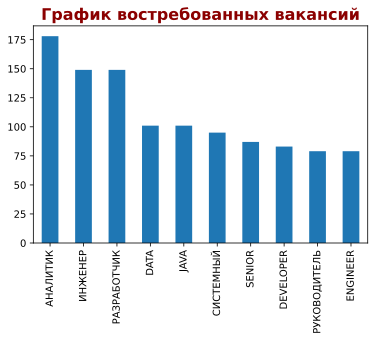

In [105]:
# Строим график выбранных вакансий
import matplotlib.pyplot as plt
%matplotlib inline
popular_vacs = pd.Series(words2).value_counts().head(10)
popular_vacs.plot(kind='bar')
plt.title('График востребованных вакансий', fontsize=16, fontweight='bold', color='DarkRed')
plt.show()

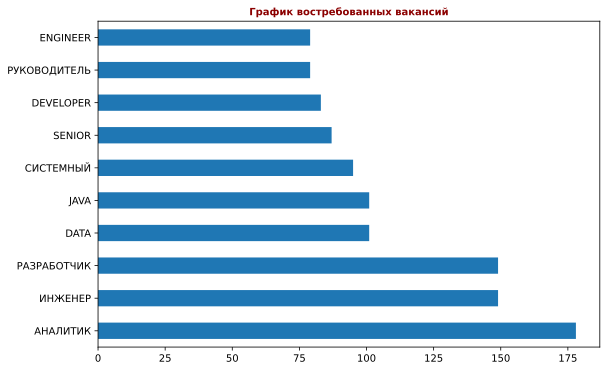

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 9,6
popular_vacs.plot(kind='barh')
plt.title('График востребованных вакансий', fontsize=10, fontweight='bold', color='DarkRed')
plt.show()